## Import Libraries

In [1]:
import spacy
import pandas as pd 
import re
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import openpyxl
from collections import Counter
import pdfx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## Load Transformer Model and Prepare Doc Element

In [2]:
nlp = spacy.load("en_core_web_trf")

In [6]:
pdf = pdfx.PDFx("/Users/mefkurehilalyaman-nevruz/Desktop/AIA/thesis_project/valo/aia_en.pdf")

In [7]:
text_aia = pdf.get_text()

In [8]:
# Doc element for the whole AIA
doc_aia = nlp(text_aia)

In [9]:
pattern = re.compile(r"(CHAPTER\s+III.*?)(?=CHAPTER\s+IV)", re.DOTALL)
match = pattern.search(text_aia)
if match:
    chapter_3 = match.group(1).strip()
    print("Match found!")
else:
    print("Match not found!")

Match found!


In [10]:
chap_3_clean = chapter_3.replace("\f", " ").replace("\n", " ").replace("\t", " ").replace("\r", " ")

In [11]:
# Doc Element for Chapter III of AIA 
doc_chap_3 = nlp(chap_3_clean)

## Functions for Part Of Speech Tagging

In [ ]:
# Extracting POS-Elements and count of occurence
excel_path = "/Users/mefkurehilalyaman-nevruz/Desktop/AIA/thesis_project/valo/pos_values.xlsx"

def extract_pos_counts(doc, excel_path):
    data = []
    for token in doc:
        data.append([token.text, token.lemma_, token.pos_,])
    
    columns = ["text", "lemma_","pos_"]
    df = pd.DataFrame(data, columns = columns)

    df_count = df.groupby(["text", "lemma_", "pos_"]).size().reset_index(name="count")
    df_count.to_excel(excel_path, sheet_name="pos", index=False)
    
    return df_count

In [ ]:
# Search in document via the target word and get the neighbor words to create value-pairs 
def search_by_word(doc, target_word, excel_path):
    data = []
    for i, token in enumerate(doc):
        if token.text == target_word:
            left_left_neighbor = doc[i-2].text if i > 0 else None
            left_neighbor = doc[i-1].text if i > 0 else None
            right_neighbor = doc[i+1].text if i < len(doc) - 1 else None
            right_right_neighbor = doc[i+2].text if i < len(doc) - 1 else None
            data.append([left_left_neighbor, left_neighbor, target_word, right_neighbor, right_right_neighbor])

    columns = ["left_left_neighbor", "left_neighbor", "target_word", "right_neighbor", "right_right_neighbor"]
    df = pd.DataFrame(data, columns=columns)

    df.to_excel(excel_path, sheet_name="neighbors", index=False)
    return df


In [ ]:

# Count how many times a word occurs in the doc element
def count_word_occurence(doc, keyword):
    keyword = keyword.lower().strip() #normalize
    count = 0
    for token in doc:
        if token.text.lower().strip() == keyword:
            count += 1
    df = pd.DataFrame({"keyword": [keyword], "count": [count]})
    return df

In [ ]:
# Find sentences by a specific keyword in the doc element
def find_sentences_with_keyword(keyword, doc):
    i = 1
    for sentence in doc.sents:
        sentence = sentence.text
        
        if keyword.lower() in sentence.lower():
            sentence = re.sub("\n", " ", sentence)
            highlighted_sentence = re.sub(
                f"({re.escape(keyword)})",
                r'<span style="color: orange; font-weight: bold;">\1</span>',
                sentence,
                flags=re.IGNORECASE
            )
            
            numbered_sentence = f"<strong>{i}:</strong> {highlighted_sentence}"
            display(HTML(numbered_sentence))
            
            i += 1

## Creating the Co-Occurence Matrix

In [12]:
df = pd.read_excel("/Users/mefkurehilalyaman-nevruz/Desktop/AIA/thesis_project/valo/aia_values_manual.xlsx", "values")

In [13]:
value_variants = df.groupby("common_term")["value"].apply(list).to_dict()

print(value_variants)

{'AI_Literacy': ['AI literacy', 'ai literacy'], 'Accountability': ['accountability', 'accountable', 'public accountability'], 'Administration': ['administration', 'administrative fine'], 'Agriculture': ['agriculture'], 'Autonomy': ['autonomy', 'personal autonomy'], 'Avoidance_Of_Administrative_Burden_Or_Cost': ['avoidance of administrative burden', 'avoidance of administrative cost', 'administrative burden', 'administrative cost'], 'Benefit_Human_Being': ['benefit all human being'], 'Best_Practice': ['best practice', 'best practices'], 'Competitiveness': ['competition law', 'competitive advantage', 'competitiveness'], 'Compliance_With_Law': ['compliance', 'compliance with aia', 'compliance with article16 tfeu', 'compliance with article4(3) directive 2019 790', 'compliance with copyright law', 'compliance with directive 2013 32 eu', 'compliance with directive 2016 680 eu', 'compliance with directive 2016/2102 eu', 'compliance with directive 2019 882 eu', 'compliance with ec 810 2009', '

In [ ]:
# Find co-occurences with the provided list of variants of values
def get_co_occurrence_matrix(doc, value_variants):
    # Initialize Counter to store co-occurrences
    co_occurrences = Counter()

    # Loop through each sentence in the document
    for sent in doc.sents:
        words_in_sentence = [token.text.lower() for token in sent]  # Convert sentence to word list

        # Track which keywords appear in this sentence
        found_keywords = set()

        for keyword, variants in value_variants.items():
            # If any variant is in the sentence, add the keyword
            for variant in variants:
                if variant.lower() in words_in_sentence:
                    found_keywords.add(keyword)
                    break  # Stop checking once a match is found for this keyword

        # Count co-occurrences for this sentence
        for key1 in found_keywords:
            for key2 in found_keywords:
                if key1 != key2:
                    co_occurrences[(key1, key2)] += 1

    # Convert co-occurrences to a DataFrame
    keywords = list(value_variants.keys())
    matrix = pd.DataFrame(0, index=keywords, columns=keywords)

    # Populate the matrix
    for (word1, word2), count in co_occurrences.items():
        matrix.loc[word1, word2] = count
        matrix.loc[word2, word1] = count  # Symmetric matrix

    return matrix

In [ ]:
# Create matrix
def create_co_occurrence_matrix(df, values):
    matrix = pd.DataFrame(0, index=values, columns=values)
    
    for _, row in df.iterrows():
        matrix.loc[row['word1'], row['word2']] = row['count']
        matrix.loc[row['word2'], row['word1']] = row['count']
    
    return matrix

In [ ]:
# Draw the matrix with the found values 
def plot_co_occurrence_matrix(matrix):
    plt.figure(figsize=(24, 20))
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt='g')
    plt.title("Co-Occurrence Matrix")
    plt.show()

In [ ]:
# Draw matrix by leaving out the values with zero occurences
def plot_co_occurrence_matrix_no_zeros(matrix):
    # Remove rows and columns that have all zeros
    matrix = matrix.loc[(matrix.sum(axis=1) > 0), (matrix.sum(axis=0) > 0)]
    
    # Plot the heatmap
    plt.figure(figsize=(24, 20))
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt='g')
    plt.title("Co-Occurrence Matrix")
    plt.show()


## Usage of the Functions defined above

In [ ]:
target_word_aia = "AI"
excel_path_neighbors_aia = "/Users/mefkurehilalyaman-nevruz/Desktop/AIA/thesis_project/valo/neighbors_aia.xlsx"

search_by_word(doc_aia, target_word_aia, excel_path_neighbors_aia)

,left_neighbor,target_word,right_neighbor
0,conformity,assessment,","
1,conformity,assessment,","


In [ ]:
target_word_chap_3 = "assessment"
excel_path_neighbors_chap_3 = "/Users/mefkurehilalyaman-nevruz/Desktop/AIA/thesis_project/valo/neighbors_chap_3.xlsx"

search_by_word(doc_chap_3, target_word_chap_3, excel_path_neighbors_chap_3)

In [26]:
extract_pos_counts(doc_chap_3, excel_path)

,text,lemma_,pos_,count
0,,,SPACE,11014
1,,,SPACE,136
2,(,(,AUX,1
3,(,(,PUNCT,218
4,),),PUNCT,255
...,...,...,...,...
1920,years,year,NOUN,9
1921,‘,',PUNCT,2
1922,’,',PUNCT,2
1923,’,’,PART,3


In [ ]:
target_word_aia = "system"
excel_path_neighbors_aia = "/Users/mefkurehilalyaman-nevruz/Desktop/AIA/thesis_project/valo/neighbors_aia.xlsx"

search_by_word(doc_aia, target_word_aia, excel_path_neighbors_aia)

,left_left_neighbor,left_neighbor,target_word,right_neighbor,right_right_neighbor
0,‘,AI,system,’,in
1,an,AI,system,include,machine
2,AI,,system,,to
3,the,AI,system,may,be
4,the,AI,system,\n,in
...,...,...,...,...,...
686,the,AI,system,",",its
687,the,,system,;,\n\n
688,centralised,,system,,for
689,the,,system,,architecture


In [ ]:
target_word_chap_3 = "risk"
excel_path_neighbors_chap_3 = "/Users/mefkurehilalyaman-nevruz/Desktop/AIA/thesis_project/valo/neighbors_chap_3.xlsx"

df = search_by_word(doc_chap_3, target_word_chap_3, excel_path_neighbors_chap_3)

In [223]:
count_word_occurence(doc_aia, "horizontal")

,keyword,count
0,horizontal,7


In [80]:
co_occurence_matrix = get_co_occurrence_matrix(doc_aia, value_variants, window_size=5)

In [ ]:
matrix = get_co_occurrence_matrix(doc_aia, value_variants)

In [25]:
print(matrix)

                        AI_Literacy  Accountability  Administration  \
AI_Literacy                       0               0               0   
Accountability                    0               0               0   
Administration                    0               0               0   
Agriculture                       0               0               0   
Autonomy                          0               0               0   
...                             ...             ...             ...   
Transparency                      0               2               1   
Transport_And_Logistic            0               0               1   
Trustworthiness                   0               0               0   
Voluntariness                     0               1               0   
Workers_Right                     0               0               0   

                        Agriculture  Autonomy  \
AI_Literacy                       0         0   
Accountability                    0         0   


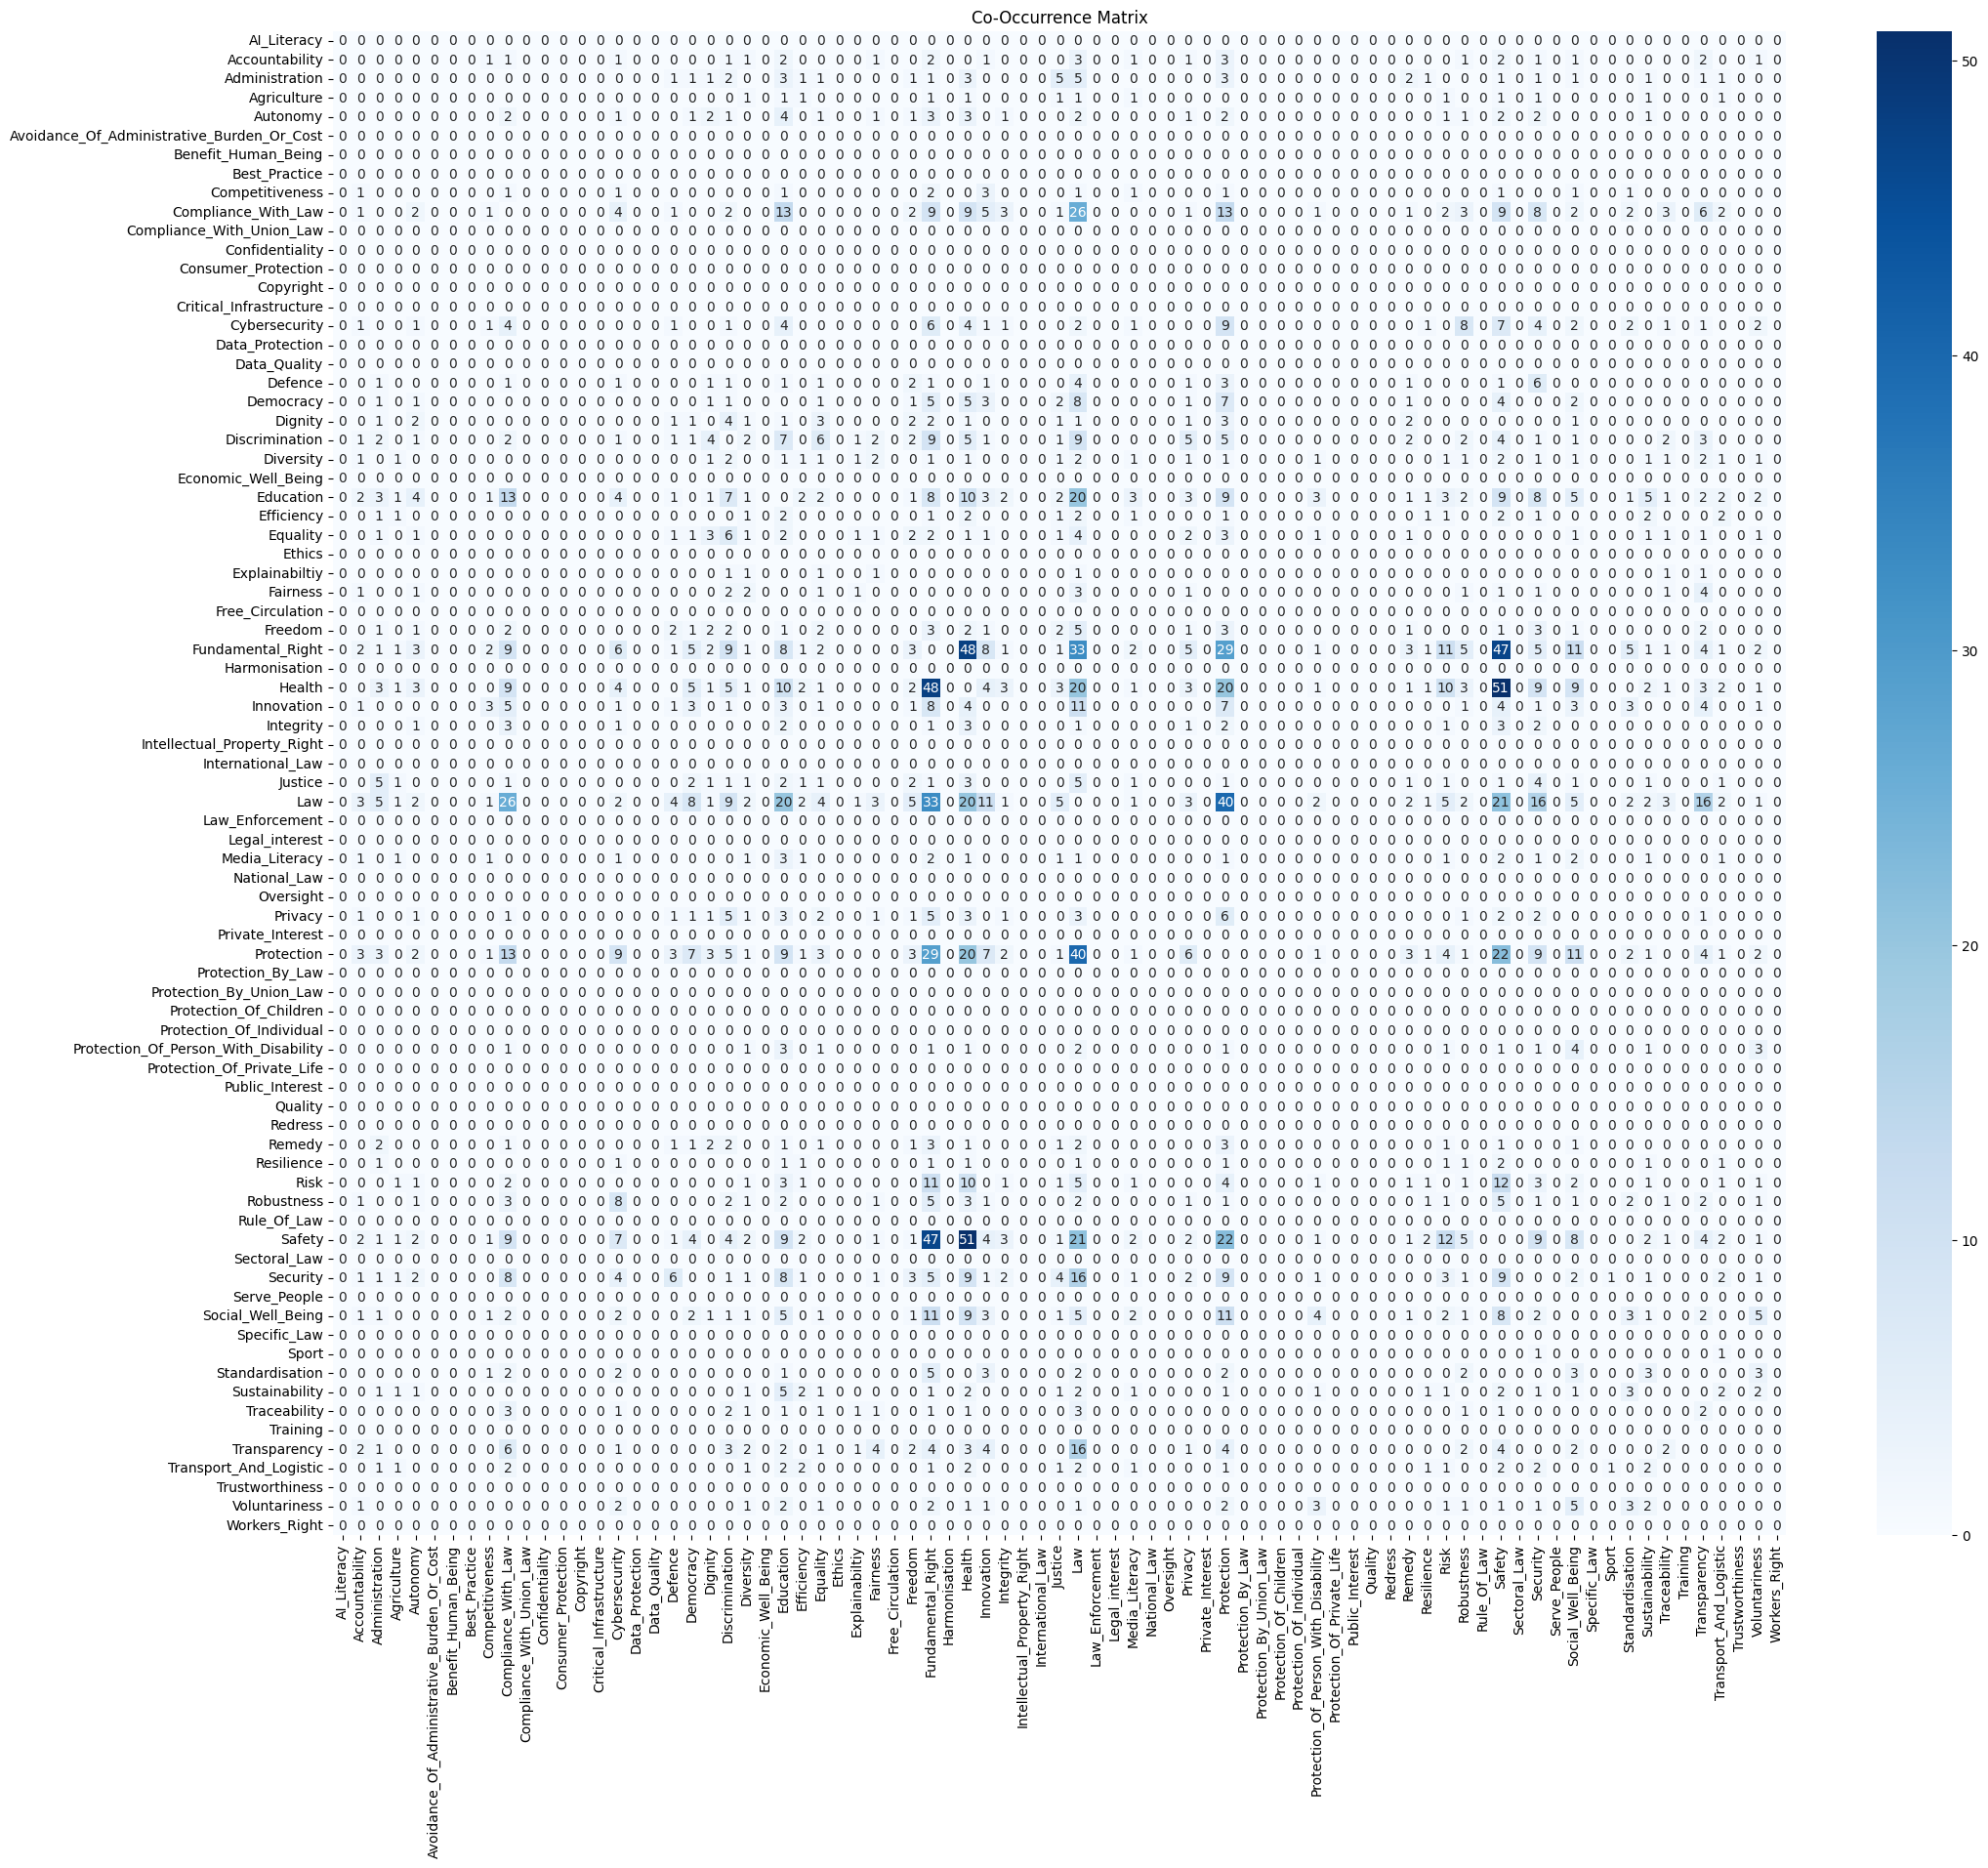

In [32]:
plot_co_occurrence_matrix(matrix)

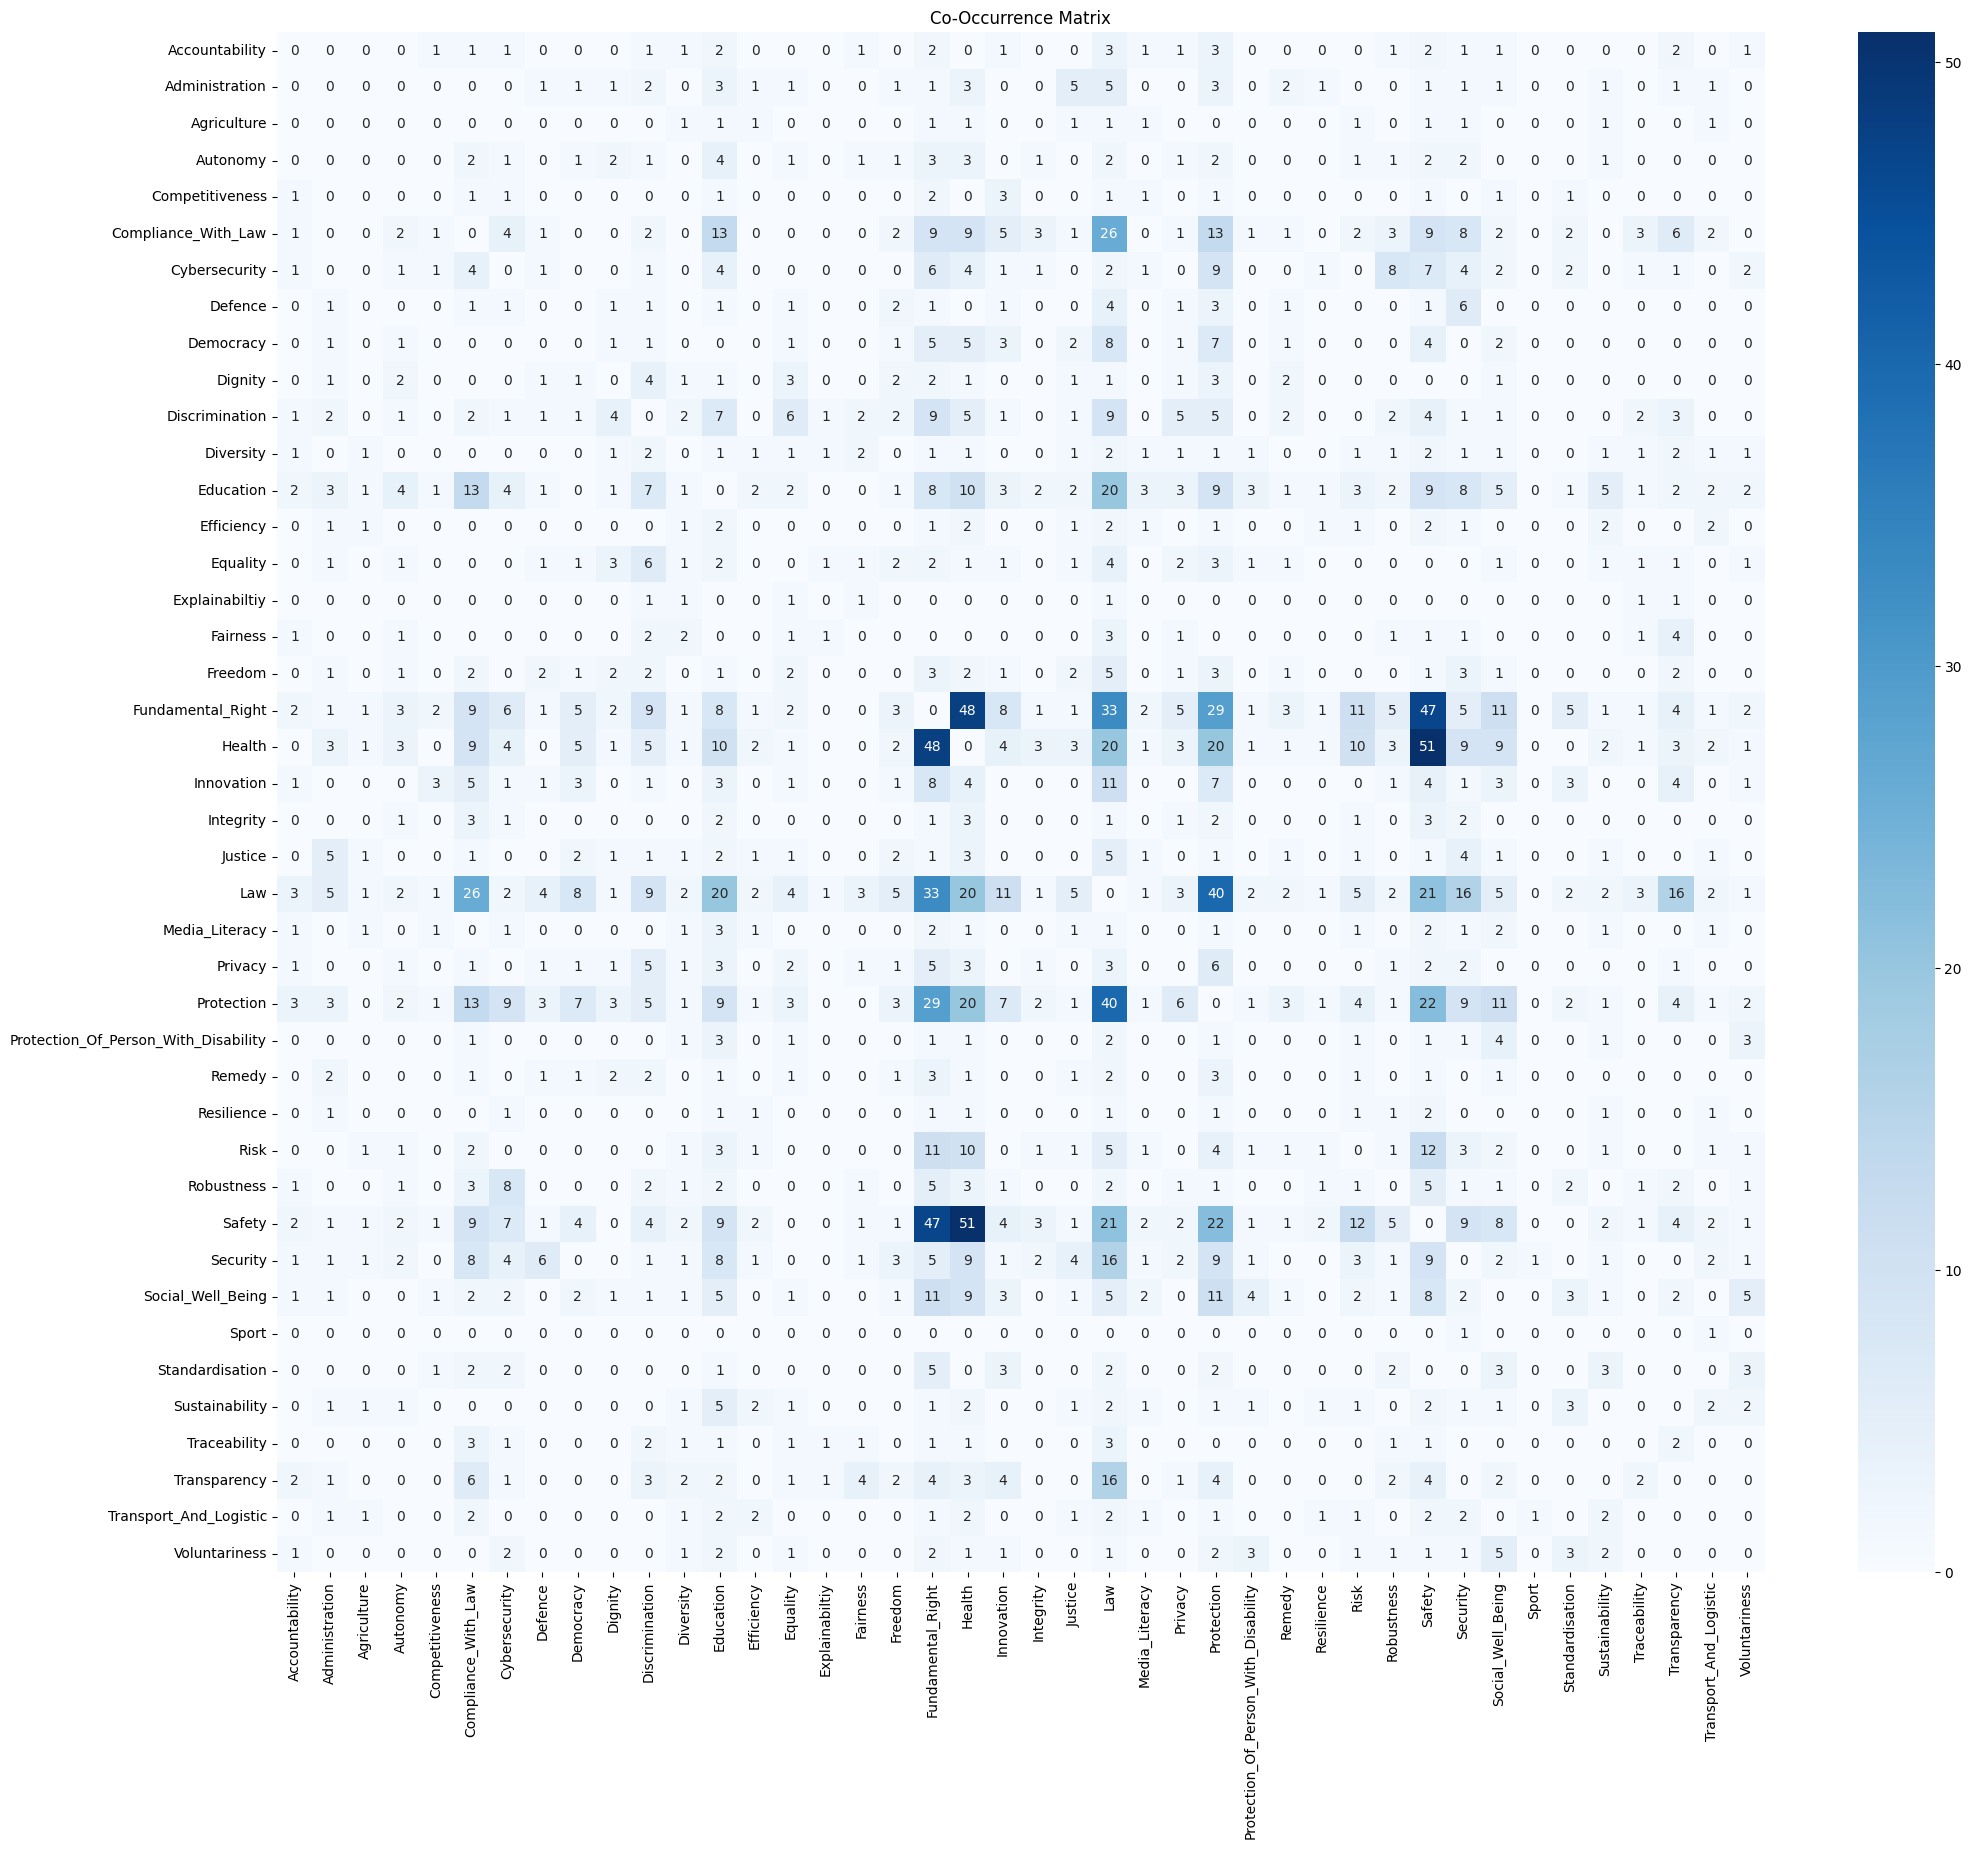

In [39]:
plot_co_occurrence_matrix_no_zeros(matrix)

In [81]:
print(co_occurence_matrix)

                   Accountability  Fundamental_Right  Health  Justice  Safety
Accountability                  0                  0       0        0       0
Fundamental_Right               0                  0       0        0       0
Health                          0                  0       0        0       1
Justice                         0                  0       0        0       0
Safety                          0                  0       1        0       0


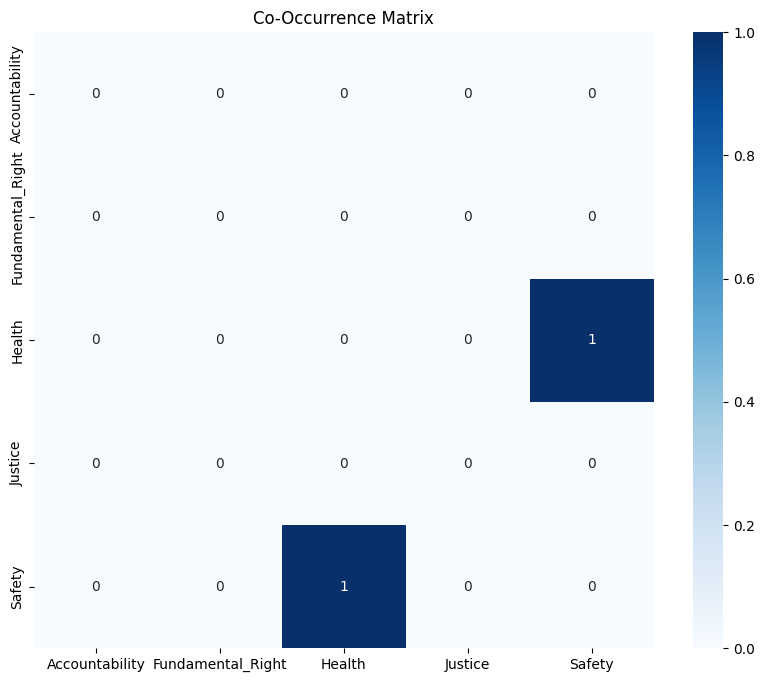

In [82]:
plot_co_occurrence_matrix(co_occurence_matrix)